<a href="https://colab.research.google.com/github/abouslima/AI-Makerspace/blob/master/VertexAI/Cifar10_VertexAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom training and prediction for Vertix AI, using [cifar10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10), from tensorflow.

The code is a short replication of this [notebook](https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/sdk-custom-image-classification-online.ipynb#scrollTo=title)


Link to the dataset: https://www.cs.toronto.edu/~kriz/cifar.html

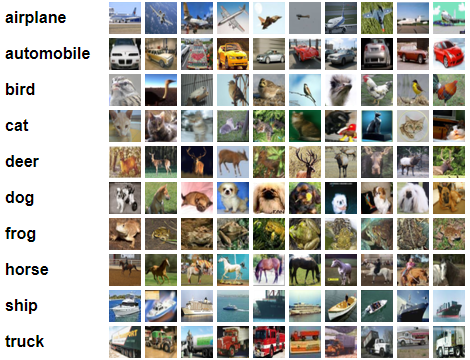

**Installing the Vertex SDK and the other dependencies for application using colab notebook**

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

! pip install {USER_FLAG} --upgrade google-cloud-aiplatform --progress-bar off
! pip install {USER_FLAG} --upgrade google-cloud-storage --progress-bar off
! pip install {USER_FLAG} --upgrade pillow --progress-bar off
! pip install {USER_FLAG} --upgrade numpy --progress-bar off

**restarting the kernel to load the installed packages**

In [1]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

**Vertex AI should be enabled within a project.**



*   Saving the timestamp to use in naming the pipeline
*   Saving the project name, the bucket for storage and the region in variables



In [1]:
from datetime import datetime
import os

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
PROJECT_ID = "vertex-ai-makerspace"  # @param {type:"string"}
BUCKET_NAME = "gs://my-ai-makerspace-bucket-cifar10"  # @param {type:"string"}
REGION = "europe-west4"  # @param {type:"string"}

**Authenticating Google Cloud account**

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

Run the following if the storage bucket isn't created in advance

In [ ]:
! gsutil mb -p $PROJECT_ID -l $REGION $BUCKET_NAME

Creating gs://my-ai-makerspace-bucket-121211222/...


Validating access to the cloud storage bucket

In [ ]:
! gsutil ls -al $BUCKET_NAME

**Importing the AI Platform library and instantiating it**

In [ ]:
from google.cloud import aiplatform
#from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

Specifiying the GPU type in case needed for training or predictions

[GPU compatibility with CPU](https://cloud.google.com/ai-platform/training/docs/using-gpus) | 
[GPU compatibility with locations](https://cloud.google.com/vertex-ai/docs/general/locations#europe_2)

[Google Cloud Partners](https://cloud.google.com/find-a-partner/)

In [ ]:
#aip.AcceleratorType.NVIDIA_TESLA_K80

TRAIN_GPU, TRAIN_NGPU = (None, None) # @param {type:"string"} 

DEPLOY_GPU, DEPLOY_NGPU = (None, None) # @param {type:"string"}

Specifiying the container for training and predictions

[Pre-Built Training Containers](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) | [Pre-Built Predicting/Deployment Containiers](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [ ]:
TRAIN_VERSION = "tf-cpu.2-1" # @param {type:"string"}
DEPLOY_VERSION = "tf2-cpu.2-1" # @param {type:"string"}

TRAIN_IMAGE = "gcr.io/cloud-aiplatform/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Specifiying training and Deployment Machine type and number of vCPU's

Types of CPU

In [ ]:
MACHINE_TYPE = "n1-standard" # @param {type:"string"}

VCPU = "8" # @param {type:"string"}
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard" # @param {type:"string"}

VCPU = "8" # @param {type:"string"}
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type n1-standard-8
Deploy machine type n1-standard-8


In [ ]:
JOB_NAME = "custom_job_" + TIMESTAMP  # the name of the experiment


if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"

EPOCHS = 20 # @param {type:"integer"}
STEPS = 100 # @param {type:"integer"}

# Defining the command arguments for the training script
CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]

The following script loads, builds, compiles, trains and save the model to the specified directory "cloud storage"

[Model Export documentation](https://cloud.google.com/vertex-ai/docs/training/exporting-model-artifacts#tensorflow)

In [ ]:
%%writefile task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling CIFAR10 data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(MODEL_DIR)

Defining the custom training job.

In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME, 
    script_path="task.py",
    container_uri=TRAIN_IMAGE, #the container image for training
    requirements=["tensorflow_datasets==1.3.0"], # any additional requirements
    model_serving_container_image_uri=DEPLOY_IMAGE, #the deployment container
)

MODEL_DISPLAY_NAME = "cifar10-" + TIMESTAMP

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
    )

**Deploying the trained model**

In [ ]:
DEPLOYED_NAME = "cifar10_deployed-" + TIMESTAMP

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

if DEPLOY_GPU:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU.name,
        accelerator_count=DEPLOY_NGPU,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )
else:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES
    )

Loading and preprocessing the test dataset

In [ ]:
# Download the images
! gsutil -m cp -r gs://cloud-samples-data/ai-platform-unified/cifar_test_images .

In [ ]:
import numpy as np
from PIL import Image

# Load image data
IMAGE_DIRECTORY = "cifar_test_images"

image_files = [file for file in os.listdir(IMAGE_DIRECTORY) if file.endswith(".jpg")]

# Decode JPEG images into numpy arrays
image_data = [
    np.asarray(Image.open(os.path.join(IMAGE_DIRECTORY, file))) for file in image_files
]

# Scale and convert to expected format
x_test = [(image / 255.0).astype(np.float32).tolist() for image in image_data]

# Extract labels from image name
y_test = [int(file.split("_")[1]) for file in image_files]

Finding the accuracy of the predictions

In [ ]:
predictions = endpoint.predict(instances=x_test)
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test))
accuracy = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {accuracy}, Accuracy = {correct/accuracy}")

If deployed using the UI

In [ ]:
ENDPOINT_ID="4759794632735326208" # @param {type:"string"}
PROJECT_ID="249560904503" # @param {type:"string"}

endpoint_name= f"projects/{PROJECT_ID}/locations/europe-west4/endpoints/{ENDPOINT_ID}"
endpoint = aiplatform.Endpoint(endpoint_name=endpoint_name)

In [ ]:
predictions = endpoint.predict(instances=x_test)
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test))
accuracy = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {accuracy}, Accuracy = {correct/accuracy}"
)

Undeploy the model

In [ ]:
deployed_model_id = endpoint.list_models()[0].id
endpoint.undeploy(deployed_model_id=deployed_model_id)